# Examine anisotropies in the directionality of the data

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from matplotlib.gridspec import GridSpec

import convenience_funcs as cfs
import load_data
import munch
import utils

matplotlib.rc("font", size=7)
matplotlib.rc("axes", titlepad=1)

save_figs = True

pdd = "../data"
fsd = "../figures"
data_in = pdd

M2 = 24.0 / 12.4206012

moorings = load_data.load_my_data()
ca, cw = load_data.load_my_data_alt()
ca = munch.munchify(ca)
cw = munch.munchify(cw)

moorings = [munch.munchify(m) for m in moorings]
cc, nw, ne, se, sw = moorings

ADCP = utils.loadmat(os.path.join(data_in, "ADCP.mat"))
ADCP = munch.munchify(ADCP)

topo = utils.loadmat(os.path.join(data_in, "topo_info.mat"))
topo = munch.munchify(topo)

# Anisotropy figure

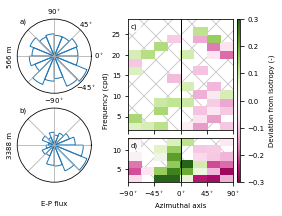

In [2]:
nazbins = 8
# nfbins = 6
sig_noise = 0.01
nperseg = 2 ** 9
Nerr = 100
cl = 95  # Confidence level
df = 2.1574e-5  # Units of... seconds?
fs = 1 / (15 * 60)  # Sampling frequency in seconds

fig = plt.figure(figsize=(3.25, 3))
gs = GridSpec(
    nrows=2,
    ncols=2,
    height_ratios=[326, 129],
    width_ratios=[100, 3],
    wspace=0.07,
    hspace=0.1,
    left=0.50,
    right=0.98,
)
axs = np.array([fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0])])
cax = fig.add_subplot(gs[:, 1])
gs1 = GridSpec(nrows=2, ncols=1, left=0.02, right=0.35)
rxs = np.array([fig.add_subplot(g_, projection="polar") for g_ in gs1])

axs[0].set_xticks(np.linspace(-np.pi / 2, np.pi / 2, 5))
axs[0].set_xticklabels([])
axs[1].set_xticks(np.linspace(-np.pi / 2, np.pi / 2, 5))
axs[1].set_xticklabels(
    ("$-90^\circ$", "$-45^\circ$", "$0^\circ$", "$45^\circ$", "$90^\circ$")
)
axs[1].set_xlabel("Azimuthal axis")
cfs.ylabel("Frequency (cpd)", fig, axs[1], axs[0], dx=-0.11)

rxs[1].set_xlabel("E-P flux")

for ax in rxs.flat:
    ax.set_xticklabels([])

# axs[j].set_ylabel("Frequency (cpd)")

for j, lev in enumerate([0, 3]):
    N = ca.N[:, lev].mean() / (np.pi * 2)
    fcor = np.abs(cc.f) / (np.pi * 2)
    use = (cw.freq > fcor) & (cw.freq < N)
    az = cw.theta[use, :, lev]
    Ndata = az.shape[1]
    freq = np.tile(cw.freq[use][:, np.newaxis], (1, Ndata))

    binsf = np.linspace(fcor, N, int(np.ceil((N - fcor) / df)))
    binsaz = np.linspace(-np.pi / 2, np.pi / 2, nazbins + 1)

    H, _, _ = np.histogram2d(freq.flatten(), az.flatten(), bins=[binsf, binsaz])
    Hf = (H - np.mean(H, axis=1, keepdims=True)) / np.mean(H, axis=1, keepdims=True)

    # Noise calculation
    ue = sig_noise * np.random.randn(nperseg, Ndata, Nerr) + cw.u[:, :, lev, np.newaxis]
    ve = sig_noise * np.random.randn(nperseg, Ndata, Nerr) + cw.v[:, :, lev, np.newaxis]

    freq, Puue = sig.welch(ue, fs, nperseg=nperseg, axis=0)
    _, Pvve = sig.welch(ve, fs, nperseg=nperseg, axis=0)
    _, Xuve = sig.csd(ue, ve, fs, nperseg=nperseg, axis=0)
    Cuve = Xuve.real

    use = (freq > fcor) & (freq < N)
    freqe = np.tile(freq[use, np.newaxis, np.newaxis], (1, Ndata, Nerr))
    azfake = (0.5 * np.arctan2(2 * Cuve, Puue - Pvve))[use, :, :]

    He = np.zeros((len(binsf) - 1, nazbins, Nerr))
    for i in range(Nerr):
        He[..., i], _, _ = np.histogram2d(
            freqe[..., i].flatten(), azfake[..., i].flatten(), bins=[binsf, binsaz]
        )

    Hfe = (He - np.mean(He, axis=1, keepdims=True)) / np.mean(He, axis=1, keepdims=True)
    bad = (
        ((Hf + np.percentile(Hfe, 100 - cl, axis=-1)) < 0)
        & ((Hf + np.percentile(Hfe, cl, axis=-1)) > 0)
    ).astype(float)
    Hf_ = np.ma.masked_where(bad, Hf)

    C = axs[j].pcolormesh(binsaz, binsf * 86400, Hf_, vmin=-0.3, vmax=0.3, cmap="PiYG")
    axs[j].patch.set(hatch="x", edgecolor="k", alpha=0.2)
    axs[j].axvline(0, color="k", linewidth=1)
    # ax.axhline(M2, color="k")

    # Polar stuff
    N_mean = ca.N[:, lev]
    uw = ca.Cuwg_int[:, lev]
    vw = ca.Cvwg_int[:, lev]
    ub = ca.Cub_int[:, lev]
    vb = ca.Cvb_int[:, lev]
    angle_EP = np.arctan2(vw + cc.f * ub / N_mean ** 2, uw - cc.f * vb / N_mean ** 2)

    # polar plots
    cfs.rose_plot(rxs[j], angle_EP, start_zero=True)

    x0 = rxs[j].get_position().x0 - 0.03
    y0 = 0.5 * (rxs[j].get_position().y0 + rxs[j].get_position().y1)
    fig.text(
        x0,
        y0,
        "{:1.0f} m".format(-ca.z[:, lev].mean()),
        rotation="vertical",
        ha="center",
        va="center",
    )

cb = plt.colorbar(C, cax, orientation="vertical")
cb.set_label("Deviation from isotropy (-)")

rxs[0].tick_params("x", pad=-3)
rxs[0].set_xticklabels(
    ["$0^\circ$", "$45^\circ$", "$90^\circ$", "", "", "", "$-90^\circ$", "$-45^\circ$"]
)

cfs.axes_labels(
    fig,
    axs,
    i0=2,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.013,
    dy=-0.04,
)

cfs.axes_labels(
    fig, rxs, dx=0.01, dy=-0.02,
)

if save_figs:
    fig_name = "anisotrpy0_4.pdf"
    fig.savefig(
        os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0.01
    )
    fig_name = "anisotrpy0_4.png"
    fig.savefig(
        os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0.01
    )

plt.show()